In [1]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline 

from dipy.sims.voxel import multi_tensor
from dipy.core.gradients import gradient_table

Specify parameters of a synthetic diffusion experiment.

In [2]:
#evals = np.array([1.5e-9, 0.4e-9]) # m^2/s
#tensorEigenvalues = np.tile(evals, (2, 1))
D0 = 2.5e-9 # m^2/s
tensorEigenvalues = D0 * np.array([[1, 0.1], [0.1, 0.01]]) # m^2/s

smallDelta = 12.9e-3 # s
bigDelta = 21.8e-3 # s
t_d = bigDelta - smallDelta/3

b_max = 1e10 # s/m^2
q_max = np.sqrt(b_max / t_d) # rad*m^-1
print(2*np.pi/q_max)
print(np.exp(-np.min(tensorEigenvalues)*q_max ** 2 * t_d))

8.31187288207e-06
0.778800783071


Thus we see that these settings mean that $\lambda = \frac{2\pi}{|q|}$ is on the order of a micrometer and that this is high enough that the signal is essentially zero at the highest q-values.

In [3]:
def get_cartesian_grid(num_each_axis=100, scale=1.):
    v, dv = np.linspace(-1, 1, num=num_each_axis, retstep=True)
    x, y = np.meshgrid(v, v)
    vecs = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))
    return scale * vecs, scale * dv

def normalize(vecs):
    norms = np.linalg.norm(vecs, axis=1)
    norms = norms[:, np.newaxis]
    not_origin = [not np.isclose(norm, 0.) for norm in norms]
    vecs[np.nonzero(not_origin), :] /= norms[np.nonzero(not_origin)]
    return vecs, norms

def get_cartesian_unit_vectors_and_norms(num_each_axis = 100):
    vecs, _ = get_cartesian_grid(num_each_axis=num_each_axis)
    unit_vecs, norms = normalize(vecs)
    return unit_vecs, norms

q_cart, _ = get_cartesian_grid(num_each_axis=5)
unit_vecs, norms = get_cartesian_unit_vectors_and_norms(num_each_axis=5)
assert(np.allclose(q_cart, norms * unit_vecs))

In [4]:
def rotation_matrix(angle_deg=90):
    theta = np.radians(angle_deg)
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([[c, -s], [s, c]])

class Multi_tensor:
    def __init__(self, evals, angles, fractions):
        self.single_tensors = [Single_tensor(evals[i, :], angles[i]) for i in range(len(angles))]
        self.fractions = fractions / np.sum(fractions)

    def signal(self, t_d, qvecs):
        S = np.zeros((qvecs.shape[0], 1))
        for i in range(len(self.fractions)):
            S += self.fractions[i] * self.single_tensors[i].signal(t_d, qvecs)
        return S

    def propagator(self, t_d, rvecs):
        P = np.zeros((rvecs.shape[0], 1))
        for i in range(len(self.fractions)):
            P += self.fractions[i] * self.single_tensors[i].propagator(t_d, rvecs)
        return P
    
    def analytic_fourier_transform(self, t_d, N, dq):
        FOV = 2*np.pi / dq
        r_max = (N-1)/N * FOV/2
        rvecs, dr = get_cartesian_grid(num_each_axis=N, scale=r_max) 
        P = self.propagator(t_d, rvecs)
        return P, rvecs

class Single_tensor:
    def __init__(self, evals, angle):
        R = rotation_matrix(angle_deg=angle)
        self.D = np.dot(np.dot(R, np.diag(evals)), R.T)

    def signal(self, t_d, qvecs):
        S = np.zeros((qvecs.shape[0], 1))
        for i, q in enumerate(qvecs):
            S[i] = np.exp(-t_d*np.dot(np.dot(q.T, self.D), q))
        return S
    
    def propagator(self, t_d, rvecs):
        P = mvn.pdf(rvecs, cov=2*t_d*self.D)
        return P[:, np.newaxis]

In [21]:
N = 99
qvecs, dq = get_cartesian_grid(num_each_axis=N, scale=q_max)

mt = Multi_tensor(tensorEigenvalues, (70, 130), (90, 10))
S = mt.signal(t_d, qvecs)
S = S.reshape(N, N)

In [15]:
b_max_augmented = 5e10 # s/m^2
q_max_augmented = np.sqrt(b_max_augmented / t_d) # rad*m^-1
scale = q_max_augmented / q_max

def upscale_by_zero_padding(S, scale=1.):
    size = np.array(S.shape)
    new_size = round_up_to_odd(scale * size)
    half_size_diff = ((new_size - size)/2).astype(int)
    padded_S = np.pad(S,
                      ((half_size_diff[0], half_size_diff[0]), (half_size_diff[1], half_size_diff[1])),
                      mode='constant',
                      constant_values=0)
    return padded_S

def round_up_to_odd(val):
    return np.ceil(val) // 2 * 2 + 1

def calculate_eap_from_signal(S, **kwargs):
    eap = np.fft.fftshift(np.fft.irfft2(np.fft.ifftshift(S), **kwargs))
    #r = np.fft.
    return eap
    

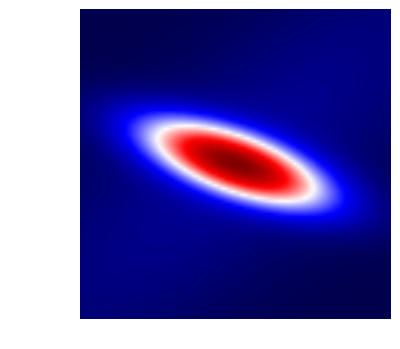

In [22]:
plt.imshow(S, interpolation='bilinear', cmap=cm.seismic,
                origin='lower', extent=[-q_max, q_max, -q_max, q_max],
                vmax=abs(S).max(), vmin=0)

plt.axis('off');

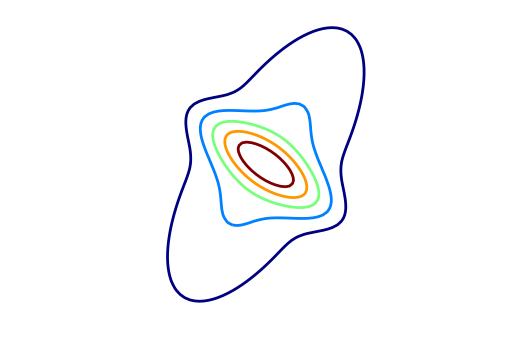

In [28]:
P, rvecs = mt.analytic_fourier_transform(t_d, N, 20*dq)
P = P.reshape(N, N)

levels = np.linspace(0, np.max(P), 7, endpoint=False);
levels = levels[2:]
plt.contour(P, levels, origin='lower', linewidths=2)
plt.axis('off');
plt.savefig('eap_2_tensor.png', transparent=True)

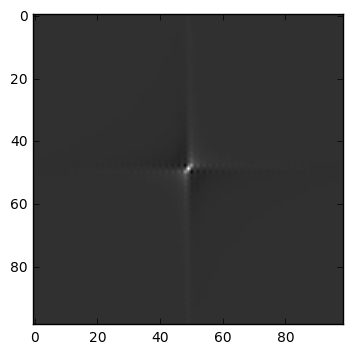

In [9]:
padded_S = upscale_by_zero_padding(S, scale=scale)
eap = calculate_eap_from_signal(padded_S, s=S.shape)
#eap = calculate_eap_from_signal(padded_S)
plt.imshow(eap, cmap=cm.gray)


In [10]:
padded_S.shape

(223, 223)